In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error #gives us more penalty for predictions that are way off, may need to adjust this metric for different data sets
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [70]:
df= pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

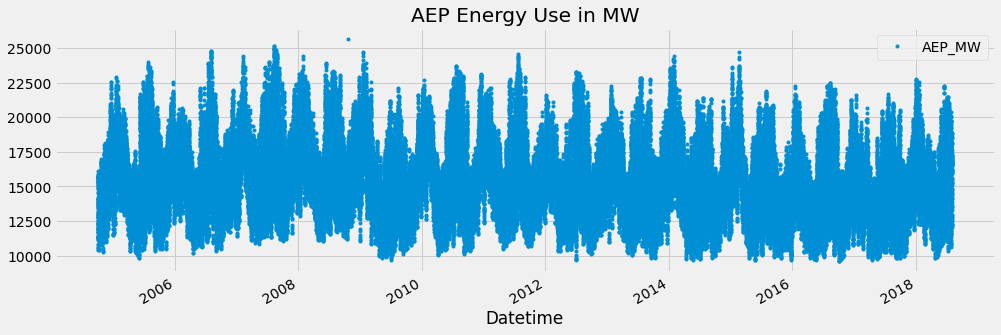

In [71]:
df.plot(style = '.', figsize=(15, 5), color = color_pal[0], title = 'AEP Energy Use in MW')
plt.show()

## Train / Test Split

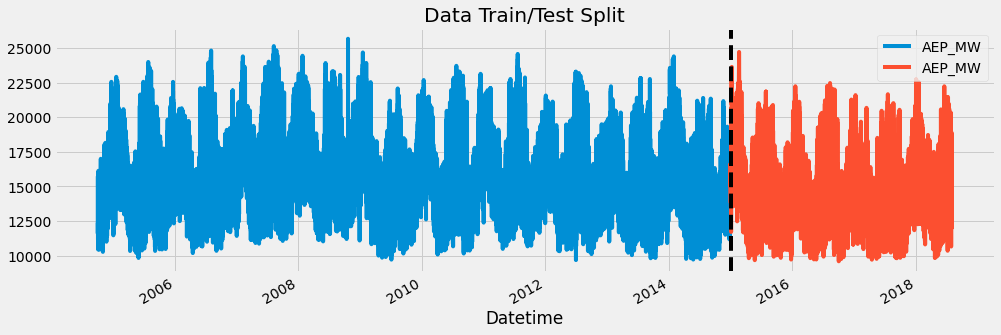

In [72]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15, 5))
train.plot(ax = ax, label = 'Training Set', title = 'Data Train/Test Split')
test.plot(ax = ax, label= 'Test Set')
ax.axvline('01-01-2015',color = 'black', ls='--' )
plt.show()


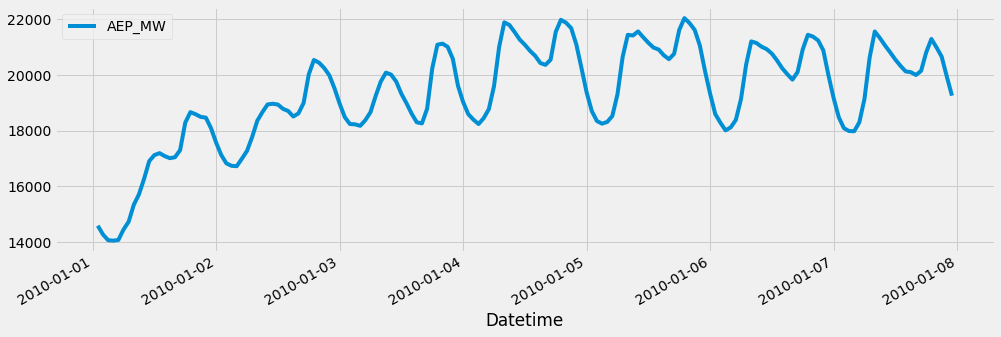

In [73]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5))
plt.show()

## Feature Creation

In [74]:
def create_features(df):
    """
    Create time series features based on time series index. 
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366


## Visualize our Feature / Target Relationship

Text(0.5, 1.0, 'MW by hour')

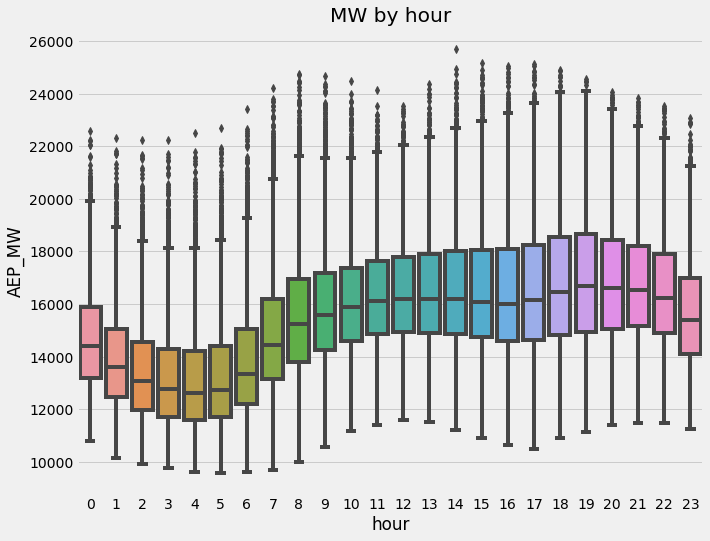

In [75]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df, x = 'hour', y = "AEP_MW")
ax.set_title('MW by hour')

Text(0.5, 1.0, 'MW by month')

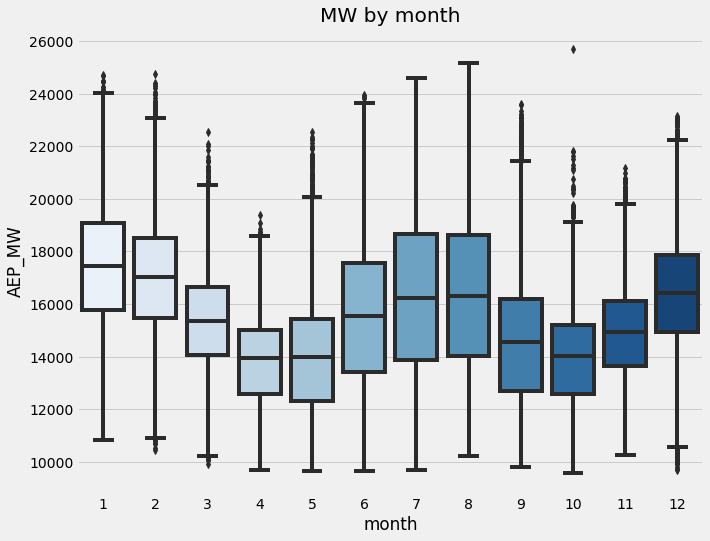

In [76]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.boxplot(data = df, x = 'month', y = "AEP_MW", palette="Blues")
ax.set_title('MW by month')

## Create our Model

In [77]:
train = create_features(train)
test = create_features(test)

In [78]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [79]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['AEP_MW']

In [80]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [81]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, 
                        learning_rate = 0.01)
reg.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)], 
        verbose = 100)

[0]	validation_0-rmse:15792.50936	validation_1-rmse:14861.30366
[100]	validation_0-rmse:5946.76890	validation_1-rmse:5177.35119
[200]	validation_0-rmse:2508.95368	validation_1-rmse:2124.36626
[300]	validation_0-rmse:1472.70614	validation_1-rmse:1577.19471
[383]	validation_0-rmse:1224.68852	validation_1-rmse:1579.14003


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

## Feature Importance

In [82]:
fi = pd.DataFrame(data=reg.feature_importances_, 
            index = reg.feature_names_in_, 
            columns = ['importance'])

<AxesSubplot:title={'center':'Feature Importance'}>

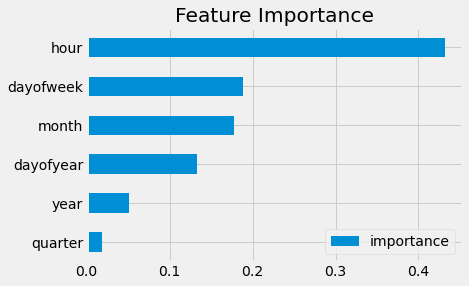

In [83]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

From the above bar chart we can see that the model has been using the hour feature the greatest. This gives us a good idea of what our model is using.

## Forecast on Test

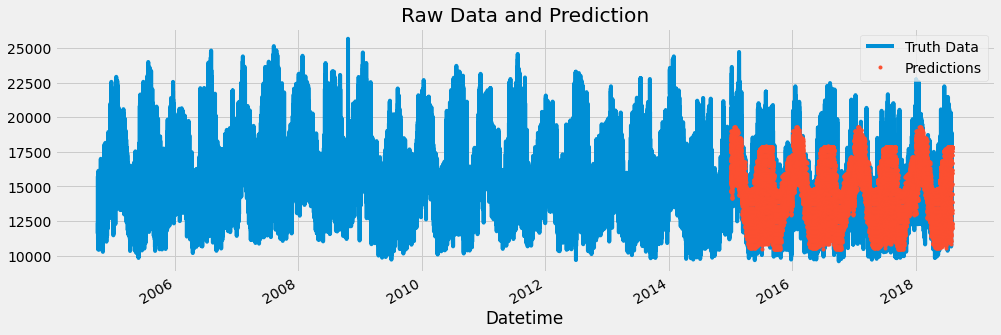

In [87]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test['prediction'], how = 'left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax =ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

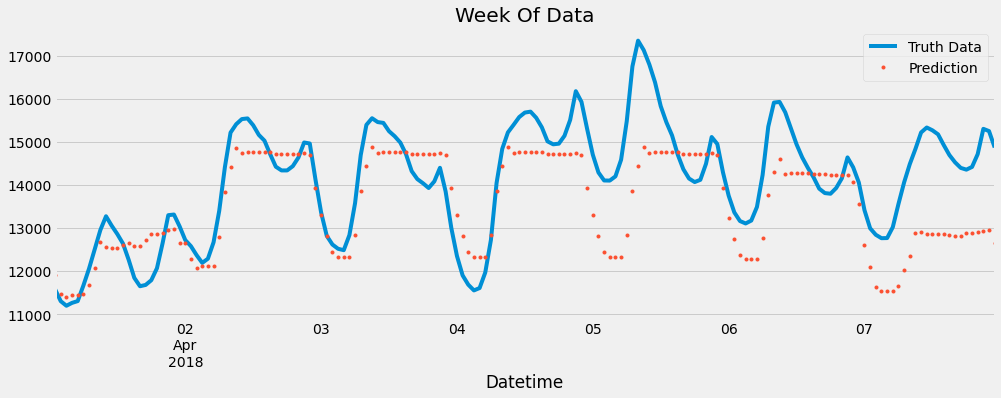

In [90]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'].plot(figsize=(15, 5), title = 'Week Of Data') #orginal data

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style = '.') #predicted data

plt.legend(['Truth Data', 'Prediction'])
plt.show()

In a future model we may be able to make its predictions more aggressive. Many imporvements to be made:
- Better parameter tuning. 
- Add in features for holidays. 

In [94]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1563.38


## Calculate Error
- Lets look at the best and worst predicted days

In [100]:
test

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,16375.0,0,3,1,1,2015,1,15764.512695
2015-12-31 01:00:00,12415.0,1,3,4,12,2015,365,14013.336914
2015-12-31 02:00:00,12087.0,2,3,4,12,2015,365,13821.142578
2015-12-31 03:00:00,12010.0,3,3,4,12,2015,365,13776.279297
2015-12-31 04:00:00,11972.0,4,3,4,12,2015,365,13776.279297
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,17494.726562
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,17494.726562
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,17489.255859


In [101]:
test['error'] = np.abs(test['AEP_MW'] - test['prediction'])

In [104]:
test['date'] = test.index.date

In [106]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2015-02-20    5461.675130
2015-02-19    5360.712606
2018-01-06    5083.077718
2018-01-07    4693.319539
2015-02-16    4321.795817
Name: error, dtype: float64

The worst predictions were made in January and February. Understanding the dates with the highest RMSE, we can focus to improve our model in these areas

In [107]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2015-09-26    207.230632
2017-05-21    210.977254
2017-11-16    213.768026
2017-10-12    220.800659
2016-06-05    222.770793
Name: error, dtype: float64

## Next Steps
- More robust cross validation
- Add more feautures (weather forecast, holidays)